8/8 [==============================] - 1s 7ms/step


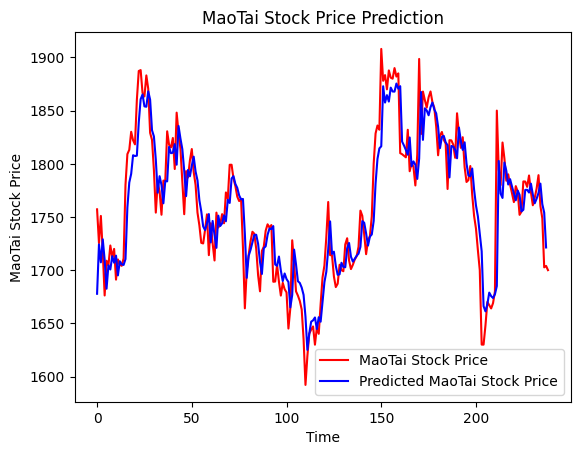

In [3]:
#maotai的GRU数据预测
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

maotai = pd.read_csv('./SH600519.csv')
training_set = maotai.iloc[0:5335 - 300, 2:3].values  # 前(2426-300=2126)天的开盘价作为训练集,表格从0开始计数，2:3 是提取[2:3)列，前闭后开,故提取出C列开盘价
test_set = maotai.iloc[5335 - 300:, 2:3].values  # 后300天的开盘价作为测试集

#归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
test_set_scaled = sc.transform(test_set) 

#创建时序数据，用前时刻数据预测后面的数据
def create_dataset(dataset, time_step=60):  #适用于二维度的数据
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		x = dataset[i:(i+time_step)]  
		y = dataset[i:(i+time_step)]
		dataX.append(x)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

train_x, train_y = create_dataset(training_set_scaled)
test_x, test_y = create_dataset(test_set_scaled)

model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(100),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
checkpoint_save_path = "./GRUcheckpoint/GRUstock.ckpt"
model.load_weights(checkpoint_save_path)

#预测和反归一化
predicted_stock_price = model.predict(test_x)

predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(test_set_scaled[60:])

#可视化
plt.plot(real_stock_price, color='red', label='MaoTai Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted MaoTai Stock Price')
plt.title('MaoTai Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MaoTai Stock Price')
plt.legend()
plt.show()